<a href="https://colab.research.google.com/github/RakhaFS/TA-AMS/blob/main/AMS_SHELL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

DENGAN FILE TRAIN DAN TEST

#Modul

In [ ]:
!pip install -U transformers --quiet

import os
os.kill(os.getpid(), 9)

In [1]:
!pip install transformers datasets evaluate wordcloud scikit-learn nltk

import pandas as pd
import numpy as np
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from transformers import DataCollatorWithPadding
from datasets import Dataset
import evaluate
import transformers
print(transformers.__version__)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.7 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


4.53.1


#Load data

In [2]:
# Load Data Train (Udah Bersih, Udah Ada Label)
Shell_tr = pd.read_csv('Shell train.csv')  # Ganti nama sesuai file lo
train = Shell_tr[['favorite_count', 'full_text', 'clean_text', 'sentiment']]  # Pastikan kolom sesuai

# Load Data Test (Data Mentah)
df = pd.read_csv("testshell.csv")
df = df[['favorite_count', 'full_text']].dropna().reset_index(drop=True)

print('Data Train sebanyak ', len(train))
print('Data Test sebanyak ', len(df))

Data Train sebanyak  919
Data Test sebanyak  513


In [4]:
po = train['sentiment'].str.contains('positive')
nt = train['sentiment'].str.contains('neutral')
ng = train['sentiment'].str.contains('negative')
# Tampilkan hasilnya

jpo = po.sum()
jnt = nt.sum()
jng = ng.sum()
print(f"Jumlah positive: {jpo}")
print(f"Jumlah neutral: {jnt}")
print(f"Jumlah negative: {jng}")

Jumlah positive: 229
Jumlah neutral: 574
Jumlah negative: 116


#Preprocessing Test

In [5]:
# Preprocessing
def preprocess(text):
    text = str(text).lower()
    text = re.sub(r'http\S+|www.\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

stop_words = set(stopwords.words('indonesian'))
custom_stopwords = {'yg', 'aja', 'dong', 'nih', 'gk', 'ga', 'kok', 'sih', 'loh', 'lah', 'nya'}
stop_words.update(custom_stopwords)

def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word not in stop_words])

df['clean_text'] = df['full_text'].apply(preprocess).apply(remove_stopwords)
df.head()

,favorite_count,full_text,clean_text
0,0,Iki shell raono cita² mbukak pom bensin ning j...,iki shell raono cita² mbukak pom bensin ning j...
1,0,@astrophilleeii @intinyadeh Iya kalo tinggal a...,iya kalo tinggal pom shell daerah smua dikuasa...
2,1,https://t.co/aryGkcEm7e Kek gini sok an pejaba...,kek gini sok an pejabat kontoi ngebatesin pemb...
3,0,@Apple__Candy13 Rute yang dilewatin gak ada po...,rute dilewatin gak pom swasta dipake motor beb...
4,0,Pengguna shell ra meh melu komen. Semenjak nga...,pengguna shell ra meh melu komen semenjak ngan...


In [6]:
# Pastikan kolom 'clean_text' dan 'sentiment' sudah ada
assert 'clean_text' in train.columns
assert 'sentiment' in train.columns

# Encode label jadi angka (positive = 2, neutral = 1, negative = 0 misalnya)
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train['label'] = label_encoder.fit_transform(train['sentiment'])

# Load test data juga, dari shell.csv yang tadi udah di-clean dan belum dilabeli
df_test = df[~df.index.isin(train.index)].reset_index(drop=True)
train.head()

,favorite_count,full_text,clean_text,sentiment,label
0,0,Disini ada yg user SPBU Shell dan payment pake...,disini ada yg user spbu shell dan payment pake...,negative,0
1,19,smg raenek spbu shell ya?,smg raenek spbu shell ya,negative,0
2,1,di serang tuh gada spbu shell kah.. ko kmrn ga...,di serang tuh gada spbu shell kah ko kmrn ga l...,negative,0
3,4,@innovacommunity Info nitro di sekitaran Tange...,innovacommunity info nitro di sekitaran tanger...,negative,0
4,1,@LexWu_13 Taun² kmrn isi bensin shell org pom ...,lexwu taun² kmrn isi bensin shell org pom ny k...,negative,0


#Load Model

In [7]:
model_name = "indobenchmark/indobert-base-p1"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(examples):
    return tokenizer(examples['clean_text'], truncation=True)

train_dataset = Dataset.from_pandas(train[['clean_text', 'label']])
test_dataset = Dataset.from_pandas(df[['clean_text']])

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Map:   0%|          | 0/919 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/513 [00:00<?, ? examples/s]

#Sentiment Analysis dengan BERT

In [8]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy.compute(predictions=preds, references=labels)["accuracy"],
        "f1": f1.compute(predictions=preds, references=labels, average="macro")["f1"]
    }

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch", # Changed from evaluation_strategy
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    save_total_limit=1,
    logging_dir="./logs"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=train_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

trainer.train()

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


/tmp/ipython-input-8-613687121.py:26: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: rakhamello11 (rakhaboy) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.644484,0.756257,0.547814
2,No log,0.386833,0.887922,0.831538
3,No log,0.278742,0.929271,0.886323


TrainOutput(global_step=174, training_loss=0.619042626742659, metrics={'train_runtime': 1911.7501, 'train_samples_per_second': 1.442, 'train_steps_per_second': 0.091, 'total_flos': 69073438874328.0, 'train_loss': 0.619042626742659, 'epoch': 3.0})

In [10]:
predictions = trainer.predict(test_dataset)
pred_labels = np.argmax(predictions.predictions, axis=-1)
df['sentiment'] = label_encoder.inverse_transform(pred_labels)

# Export CSV hasil
df[['favorite_count', 'full_text', 'clean_text', 'sentiment']].to_csv("hasil_finetune_trainshell.csv", index=False)
print("✅ Hasil disimpan ke 'hasil_finetune_sentimen.csv'")

✅ Hasil disimpan ke 'hasil_finetune_sentimen.csv'


In [11]:
look = df[['full_text','clean_text','sentiment']]
look.head()

,full_text,clean_text,sentiment
0,Iki shell raono cita² mbukak pom bensin ning j...,iki shell raono cita² mbukak pom bensin ning j...,neutral
1,@astrophilleeii @intinyadeh Iya kalo tinggal a...,iya kalo tinggal pom shell daerah smua dikuasa...,neutral
2,https://t.co/aryGkcEm7e Kek gini sok an pejaba...,kek gini sok an pejabat kontoi ngebatesin pemb...,neutral
3,@Apple__Candy13 Rute yang dilewatin gak ada po...,rute dilewatin gak pom swasta dipake motor beb...,neutral
4,Pengguna shell ra meh melu komen. Semenjak nga...,pengguna shell ra meh melu komen semenjak ngan...,neutral


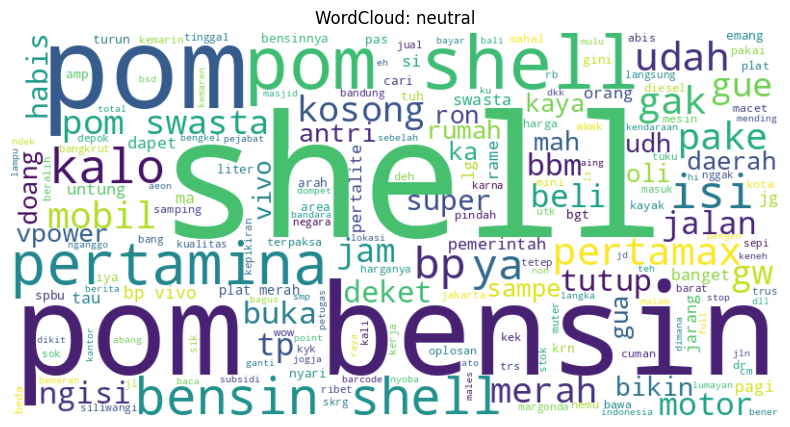

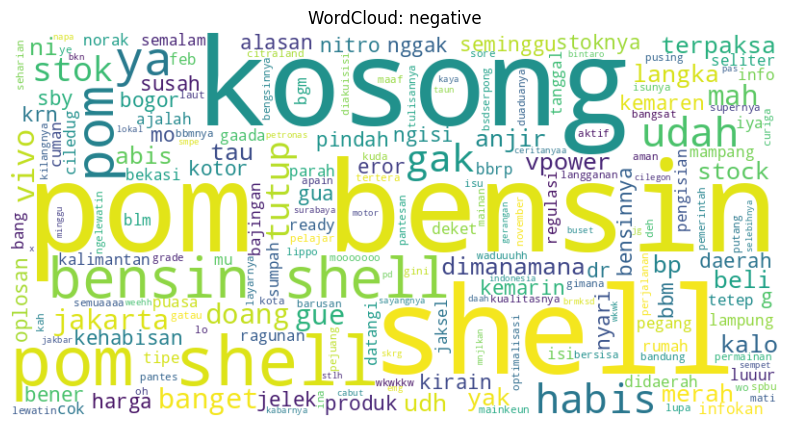

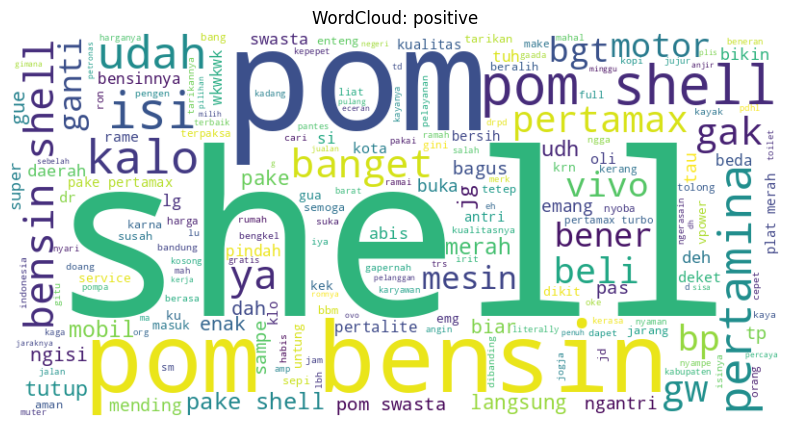

In [12]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

for label in df['sentiment'].unique():
    text = ' '.join(df[df['sentiment'] == label]['clean_text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"WordCloud: {label}")
    plt.show()